In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [3]:
from ema_workbench import (
    load_results,
)
from ema_workbench.analysis import dimensional_stacking, feature_scoring

In [4]:
path = '../results/'
file_name = '2000_scen__AGGD_reps__0612'
file_ext  = '.tar.gz'

In [5]:
experiments, outcomes = load_results(path+file_name+file_ext)

### Set-up

In [6]:
experiments.head(3)

,debt_sales_ratio,wage_sensitivity_prod,init_markup,capital_firm_cap_out_ratio,min_unempl_emigration,migration_unempl_bounds_diff,deu_discount_factor,flood_timing,scenario,policy,model
0,3.974297,0.712775,0.099379,0.297524,0.040977,0.136866,0.956540,33.0,0,NaN,CRAB
1,4.388648,0.624767,0.069494,0.246466,0.031566,0.160825,0.857878,76.0,1,NaN,CRAB
2,3.970944,0.929448,0.489306,0.339357,0.051214,0.166170,0.954534,34.0,2,NaN,CRAB


In [7]:
uncertainties = list(experiments.columns)

In [8]:
cluster_vars = []
for col in uncertainties:
    if col.split(' ')[0] == 'Cluster':
        cluster_vars.append(col)

In [9]:
for col in cluster_vars + ['scenario', 'policy', 'model', 'seed']:
    try:
        uncertainties.remove(col)
    except:
        pass
uncertainties

['debt_sales_ratio',
 'wage_sensitivity_prod',
 'init_markup',
 'capital_firm_cap_out_ratio',
 'min_unempl_emigration',
 'migration_unempl_bounds_diff',
 'deu_discount_factor',
 'flood_timing']

#### A brief look

In [10]:
experiments.describe()

,debt_sales_ratio,wage_sensitivity_prod,init_markup,capital_firm_cap_out_ratio,min_unempl_emigration,migration_unempl_bounds_diff,deu_discount_factor,flood_timing,scenario,policy
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,0.0
mean,2.899981,0.500001,0.275003,0.400001,0.050000,0.175000,0.899999,54.998000,999.500000,NaN
std,1.212716,0.288752,0.129938,0.115499,0.017325,0.043312,0.057751,14.721901,577.494589,NaN
min,0.800678,0.000253,0.050066,0.200024,0.020027,0.100042,0.800083,30.000000,0.000000,NaN
25%,1.850476,0.249949,0.162536,0.300112,0.034998,0.137520,0.850041,42.000000,499.750000,NaN
50%,2.900270,0.500048,0.275036,0.399957,0.050000,0.175010,0.899961,55.000000,999.500000,NaN
75%,3.949368,0.749836,0.387371,0.499888,0.064984,0.212491,0.949987,68.000000,1499.250000,NaN
max,4.998699,0.999995,0.499972,0.599861,0.079991,0.249927,0.999952,80.000000,1999.000000,NaN


##### ...and a sidebar for the outcomes

In [11]:
N_RUNS = None
N_STEPS = None
N_OUTCOMES = len(outcomes)

for key in outcomes:
    if N_RUNS is None:
        N_RUNS = len(outcomes[key])
        N_STEPS = len(outcomes[key][0])
    else:
        assert(len(outcomes[key]) == N_RUNS)
        assert(len(outcomes[key][0]) == N_STEPS)

print(f'Dataset has {N_OUTCOMES} outcomes for {N_RUNS} runs each of length {N_STEPS}')
print(f'Dataset has outcomes: {[key for key in outcomes]}')

Dataset has 15 outcomes for 2000 runs each of length 120
Dataset has outcomes: ['MEAN(Household Population)', 'STD(Household Population)', 'VAR(Household Population)', 'MEAN(GDP)', 'STD(GDP)', 'VAR(GDP)', 'MEAN(Gini Coefficient)', 'STD(Gini Coefficient)', 'VAR(Gini Coefficient)', '95CI_HI(Household Population)', '95CI_LO(Household Population)', '95CI_HI(GDP)', '95CI_LO(GDP)', '95CI_HI(Gini Coefficient)', '95CI_LO(Gini Coefficient)']


#### Dimensional Stack (ish) to demonstrate uncertainty space coverage

In [12]:
# def pivot_plot_space_filling(experiments, uncertainties, nbins=2, bin_labels=False):
#     n = len(uncertainties)
#     if n % 2 != 0:
#         uncertainties = uncertainties[:-1]
#         n = len(uncertainties)
#     nr_levels = n / 2

#     x = experiments[uncertainties]

#     rows = list(uncertainties[0:n:2])
#     columns = list(uncertainties[1:n:2])

In [13]:
def plot_pivot_table(
    table, plot_labels=True, plot_cats=True, figsize=(10, 10), cmap="viridis", **kwargs
):
    """visualize a pivot table using colors

    Parameters
    ----------
    table : Pandas DataFrame
    plot_labels : bool, optional
                 if true, display uncertain factor names
    plot_cats : bool, optional
                 if true, display category labels for each uncertain factor
    fig_size : tuple of 2 ints, optional
               size of the figure to create
    cmap : matplotlib colormap name or object, optional
           default is viridis (requires matplotlib 1.5 or higher)
    kwargs : other keyword arguments
             All other keyword arguments are passed to ax.pcolormesh.

    Returns
    -------
    Figure

    """

    with sns.axes_style("white"):
        fig = plt.figure(figsize=figsize)

        width_ratios = dimensional_stacking.dim_ratios(figsize=figsize, axis=1)
        height_ratios = dimensional_stacking.dim_ratios(figsize=figsize, axis=0)

        gs = mpl.gridspec.GridSpec(
            3, 3, wspace=0.01, hspace=0.01, width_ratios=width_ratios, height_ratios=height_ratios
        )

        ax_plot = fig.add_subplot(gs[2, 2])
        ax_rows = fig.add_subplot(gs[2, 0:2], facecolor="white")
        ax_cols = fig.add_subplot(gs[0:2, 2], facecolor="white")
        cax = fig.add_subplot(gs[0, 0])

        # actual plotting
        plot_data = table.values
        sns.heatmap(plot_data, ax=ax_plot, cbar_ax=cax, cmap=cmap, vmin=0, vmax=np.nanmax(plot_data), **kwargs)

        # set the tick labels
        ax_plot.set_xticks([])
        ax_plot.set_yticks([])

        # plot row labeling
        ax_rows.set_ylim(ax_plot.get_ylim())
        ax_rows.set_xlim(0, 1)
        dimensional_stacking.plot_index(
            ax_rows,
            ax_plot,
            axis=1,
            index=table.index,
            plot_labels=plot_labels,
            plot_cats=plot_cats,
        )

        # plot column labeling
        ax_cols.set_xlim(ax_plot.get_xlim())
        ax_cols.set_ylim(0, 1)
        dimensional_stacking.plot_index(
            ax_cols,
            ax_plot,
            axis=0,
            index=table.columns,
            plot_labels=plot_labels,
            plot_cats=plot_cats,
        )

    return fig

In [14]:
def create_pivot_plot(x, y, nr_levels=3, labels=True, categories=True, nbins=3, bin_labels=False):
    
    x = dimensional_stacking._prepare_experiments(x)
    scores = feature_scoring.get_ex_feature_scores(x, y)[0]
    x = x[scores.index]

    n = nr_levels * 2

    scores = scores.index.tolist()
    rows = list(scores[0:n:2])
    columns = list(scores[1:n:2])

    discretized_x = dimensional_stacking.discretize(x, nbins=nbins, with_labels=bin_labels)

    ooi_label = "y"
    ooi = pd.DataFrame(y[:, np.newaxis], columns=[ooi_label])

    x_y_concat = pd.concat([discretized_x, ooi], axis=1)
    pvt = pd.pivot_table(x_y_concat, values=ooi_label, index=rows, columns=columns, aggfunc="sum", dropna=False)

    fig = plot_pivot_table(pvt, plot_labels=labels, plot_cats=categories)
    return fig

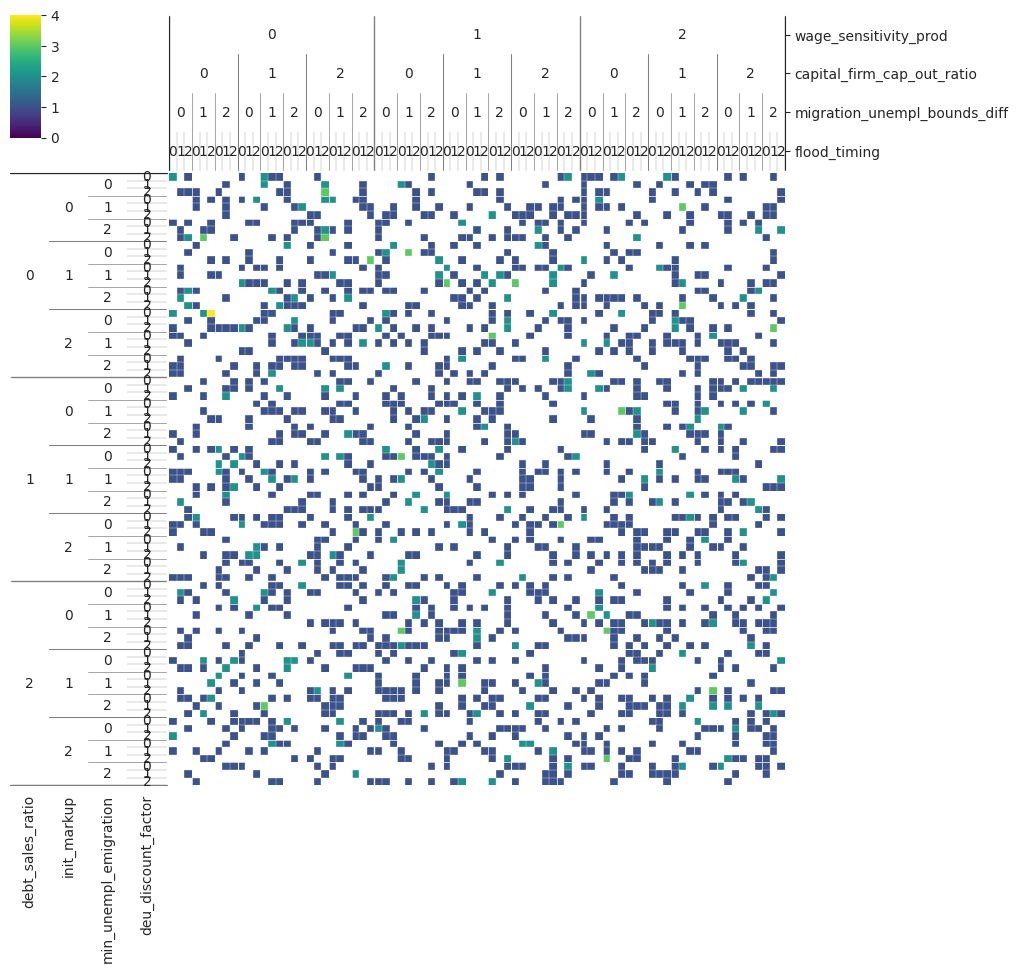

In [15]:
from ema_workbench.analysis import dimensional_stacking

x = experiments[uncertainties]
y = np.array(experiments["model"] == "CRAB")
# y = np.array([pop[-1] > 10000 for pop in outcomes['Household Population']])
pvt = create_pivot_plot(x, y, nr_levels=4, nbins=3, bin_labels=False)
plt.show()

In [20]:
experiments

,debt_sales_ratio,wage_sensitivity_prod,init_markup,capital_firm_cap_out_ratio,min_unempl_emigration,migration_unempl_bounds_diff,deu_discount_factor,flood_timing,scenario,policy,model
0,3.974297,0.712775,0.099379,0.297524,0.040977,0.136866,0.956540,33.0,0,NaN,CRAB
1,4.388648,0.624767,0.069494,0.246466,0.031566,0.160825,0.857878,76.0,1,NaN,CRAB
2,3.970944,0.929448,0.489306,0.339357,0.051214,0.166170,0.954534,34.0,2,NaN,CRAB
3,0.972112,0.595822,0.229186,0.399390,0.058033,0.145984,0.827532,46.0,3,NaN,CRAB
4,2.097049,0.085739,0.102101,0.530068,0.059356,0.146438,0.858569,72.0,4,NaN,CRAB
...,...,...,...,...,...,...,...,...,...,...,...
1995,3.200478,0.471664,0.139773,0.390861,0.037946,0.242404,0.825514,61.0,1995,NaN,CRAB
1996,3.591290,0.208159,0.338511,0.324545,0.050687,0.220237,0.821360,44.0,1996,NaN,CRAB
1997,4.485911,0.554342,0.224410,0.422127,0.071176,0.202716,0.821195,40.0,1997,NaN,CRAB
1998,1.809927,0.981881,0.183219,0.200401,0.037715,0.114086,0.970333,69.0,1998,NaN,CRAB


In [22]:
from ema_workbench.analysis import pairs_plotting

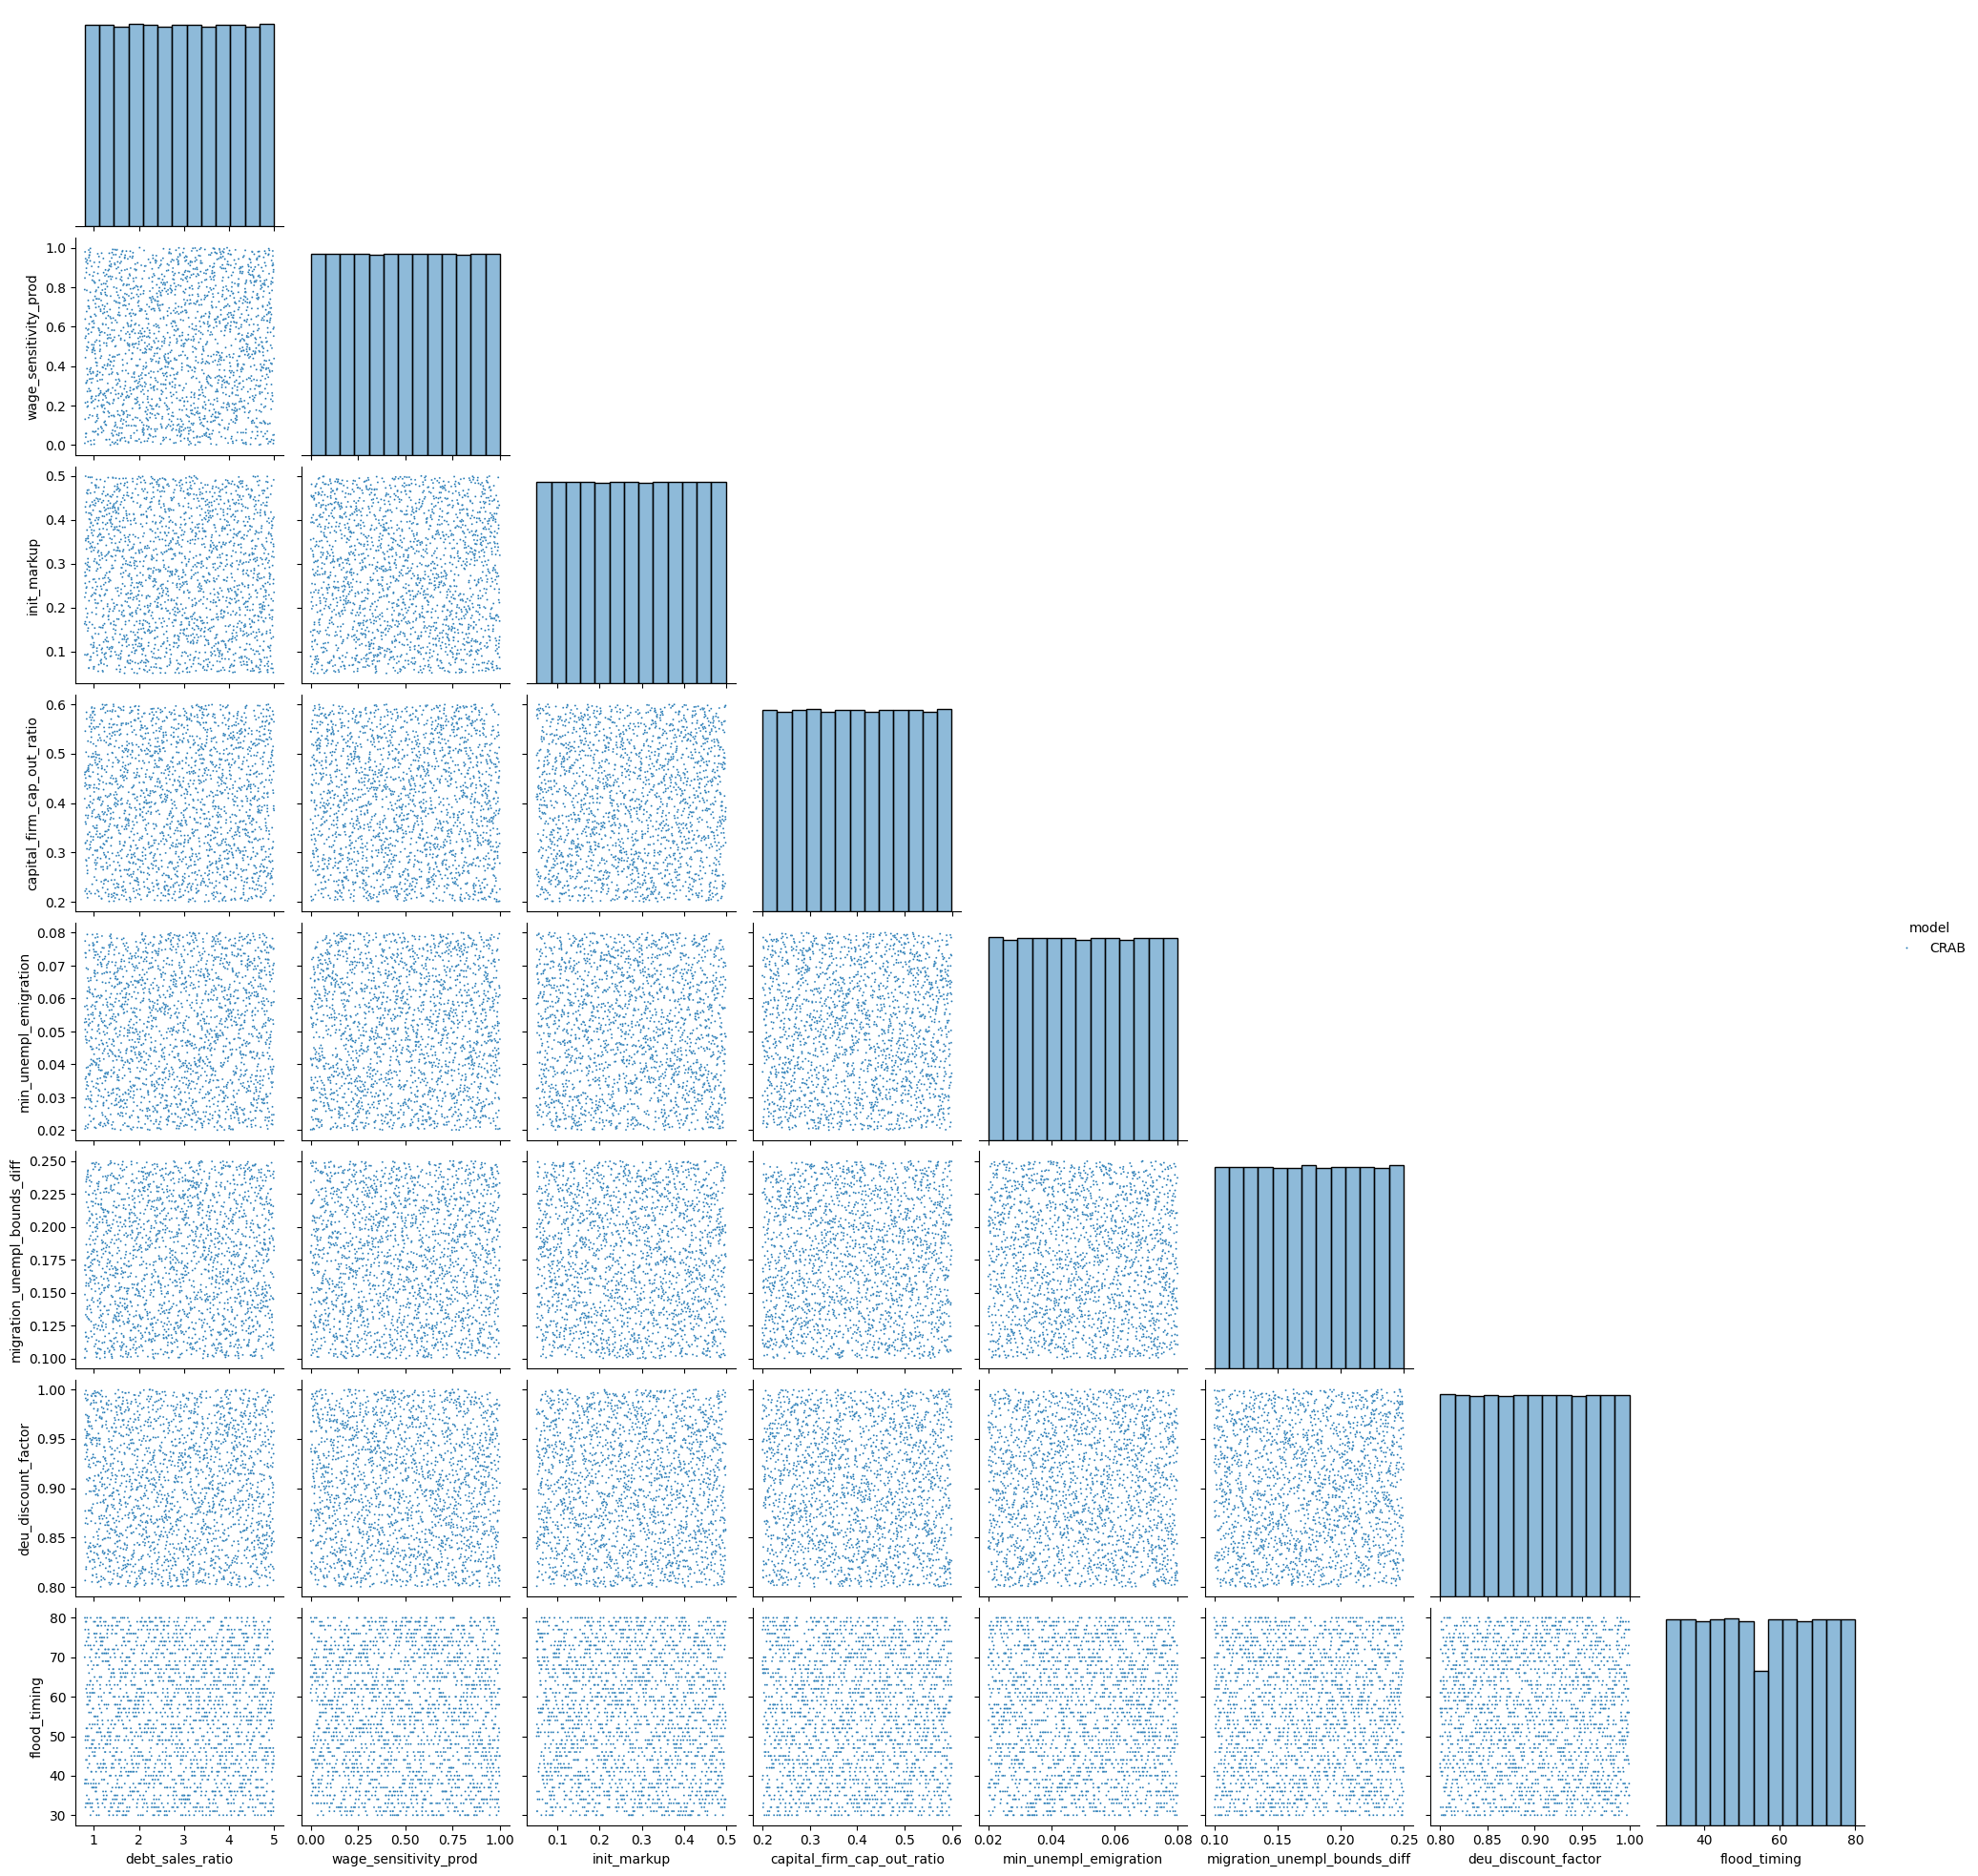

In [30]:
g = sns.pairplot(
    experiments,
    hue='model',
    vars=uncertainties,
    plot_kws=dict(s=2),
    diag_kind='hist',
    palette='tab10',
    corner=True,
)
plt.show()

#### Old stuff, mostly time-series plotting from pre-dashboard. Requires old data format

In [21]:
# # ReplicatorModel-->Model
# new_outcomes = {}
# for var in outcomes:
#     new_outcomes[var] = []
#     for a in outcomes[var]:
#         new_outcomes[var].append(list(a[0]))
#     outcomes[var] = np.array(new_outcomes[var])

### Exploring the experiment space

In [22]:
experiments.head()

,debt_sales_ratio,wage_sensitivity_prod,init_markup,capital_firm_cap_out_ratio,min_unempl_emigration,migration_unempl_bounds_diff,deu_discount_factor,flood_timing,scenario,policy,model
0,3.974297,0.712775,0.099379,0.297524,0.040977,0.136866,0.956540,33.0,0,NaN,CRAB
1,4.388648,0.624767,0.069494,0.246466,0.031566,0.160825,0.857878,76.0,1,NaN,CRAB
2,3.970944,0.929448,0.489306,0.339357,0.051214,0.166170,0.954534,34.0,2,NaN,CRAB
3,0.972112,0.595822,0.229186,0.399390,0.058033,0.145984,0.827532,46.0,3,NaN,CRAB
4,2.097049,0.085739,0.102101,0.530068,0.059356,0.146438,0.858569,72.0,4,NaN,CRAB


In [23]:
experiments.describe()

,debt_sales_ratio,wage_sensitivity_prod,init_markup,capital_firm_cap_out_ratio,min_unempl_emigration,migration_unempl_bounds_diff,deu_discount_factor,flood_timing,scenario,policy
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,0.0
mean,2.899981,0.500001,0.275003,0.400001,0.050000,0.175000,0.899999,54.998000,999.500000,NaN
std,1.212716,0.288752,0.129938,0.115499,0.017325,0.043312,0.057751,14.721901,577.494589,NaN
min,0.800678,0.000253,0.050066,0.200024,0.020027,0.100042,0.800083,30.000000,0.000000,NaN
25%,1.850476,0.249949,0.162536,0.300112,0.034998,0.137520,0.850041,42.000000,499.750000,NaN
50%,2.900270,0.500048,0.275036,0.399957,0.050000,0.175010,0.899961,55.000000,999.500000,NaN
75%,3.949368,0.749836,0.387371,0.499888,0.064984,0.212491,0.949987,68.000000,1499.250000,NaN
max,4.998699,0.999995,0.499972,0.599861,0.079991,0.249927,0.999952,80.000000,1999.000000,NaN
